needed imports

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning
import pickle
import os.path
from os import path
import numpy as np
from keras.utils import plot_model
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Dropout,AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, Activation, LeakyReLU
from tensorflow.linalg import matmul, matrix_transpose
from keras.losses import kullback_leibler_divergence, binary_crossentropy
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow import cast
from keras.optimizers import Adam
from keras.datasets import mnist, fashion_mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer = Adam(0.0002,0.5)
thr_value=0.1
L1_weight=1.5
sparse_dim = 28*28
img_rows,img_cols,channels = 28,28,1

create model

In [0]:
# would cause small entries in absulute values to be set to zero and will create sparse vectors
def soft_threshlding(x):
  above_thr_pos = x * cast(x >= thr_value, tf.float32)
  below_thr_neg = x * cast(x <= -thr_value, tf.float32)
  return (above_thr_pos + below_thr_neg)

get_custom_objects().update({'soft_threshlding': Activation(soft_threshlding)})

# define the standalone discriminator model
def define_pursuit(in_shape=(28,28,1),sparse_dim = 28*28):
  model = Sequential()
  # normal
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # to vector
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(sparse_dim,name="to_sparse_dim"))
  model.add(Activation(soft_threshlding, name='soft_threshlding'))
  return model

load D

In [55]:
#dictionary file name
file_name = "dictionary20.pkl"

with open(file_name, 'rb') as input:
  d = pickle.load(input)
  dictionary_loaded2 = np.transpose(d.components_)
  # print(d)
print("loaded dictionary")
dictionary_loaded2.shape

loaded dictionary


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DictionaryLearning from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(784, 784)

generate complete model

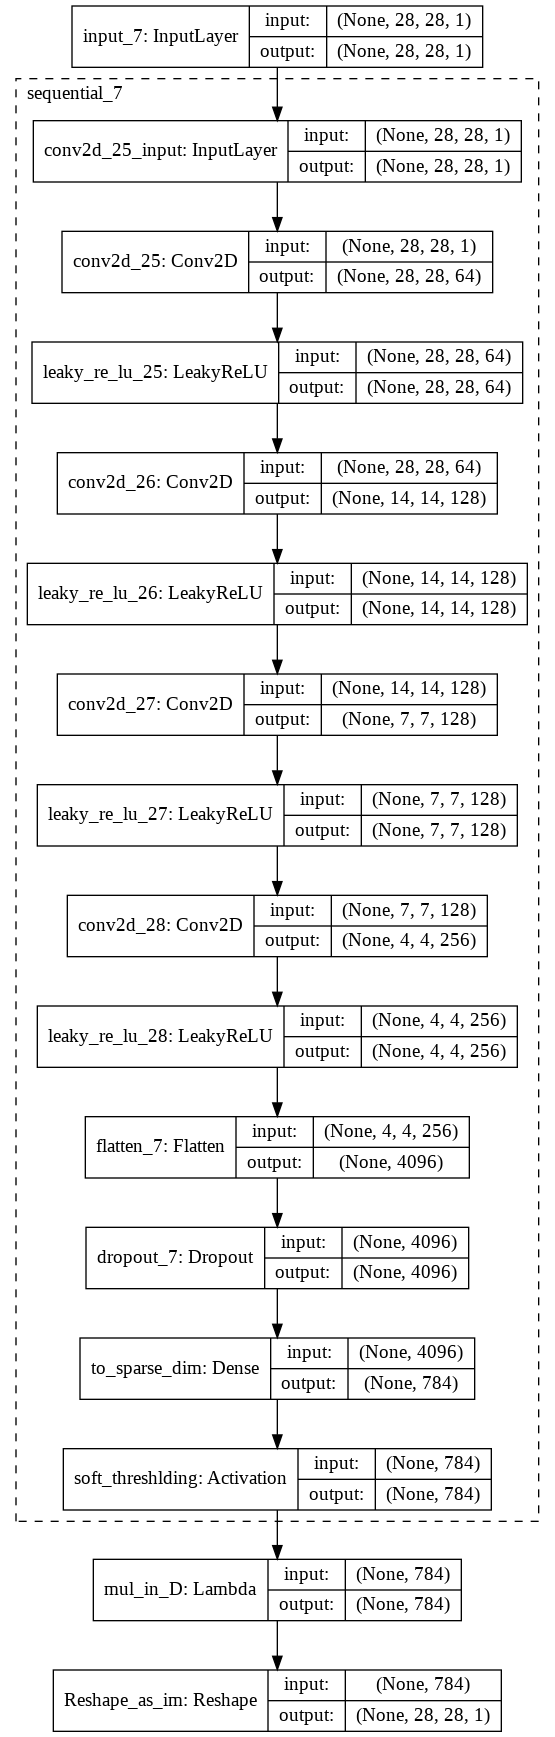

In [75]:
pursuiter = define_pursuit()
model_input = Input(shape=(28,28,1,))
sparse_vec = pursuiter(model_input)   # sparse_dim size - it is thresholded
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(tf.cast(dictionary_loaded2,tf.float32),matrix_transpose(x))),name='mul_in_D')(sparse_vec)
fake_image = Reshape((img_rows, img_cols, channels),name="Reshape_as_im")(fake_image_vec)
model = Model(model_input, [fake_image,sparse_vec])
model.compile(loss=['mean_squared_error','mean_absolute_error'], optimizer=optimizer,loss_weights=[1,L1_weight])
plot_model(model, to_file='model.png',show_shapes=True,expand_nested=True)

Train

In [76]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalization
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1
x_test = (x_test.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1
x_train = x_train.reshape(-1, img_rows,img_cols,channels) # each image as vector
x_test = x_test.reshape(-1, img_rows,img_cols,channels) # each image as vector

zeros = np.zeros(x_train.shape)
zeros = zeros.reshape(-1,img_rows*img_cols*channels)
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',baseline=None, restore_best_weights=True)

model.fit(x=x_train,y=[x_train, zeros],batch_size=32,epochs=50,validation_split=0.1,callbacks=[earlyStop])
model.save('trained_pursuiter.h5')

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 13s 246us/step - loss: 0.1914 - Reshape_as_im_loss: 0.1010 - sequential_7_loss: 0.0603 - val_loss: 0.1540 - val_Reshape_as_im_loss: 0.0761 - val_sequential_7_loss: 0.0520
Epoch 2/50
54000/54000 [==============================] - 13s 241us/step - loss: 0.1568 - Reshape_as_im_loss: 0.0637 - sequential_7_loss: 0.0621 - val_loss: 0.1430 - val_Reshape_as_im_loss: 0.0600 - val_sequential_7_loss: 0.0554
Epoch 3/50
54000/54000 [==============================] - 13s 243us/step - loss: 0.1504 - Reshape_as_im_loss: 0.0589 - sequential_7_loss: 0.0610 - val_loss: 0.1387 - val_Reshape_as_im_loss: 0.0610 - val_sequential_7_loss: 0.0519
Epoch 4/50
54000/54000 [==============================] - 13s 241us/step - loss: 0.1467 - Reshape_as_im_loss: 0.0567 - sequential_7_loss: 0.0600 - val_loss: 0.1363 - val_Reshape_as_im_loss: 0.0602 - val_sequential_7_loss: 0.0508
Epoch 5/50
54000/54000 [===========

average support =  99.2


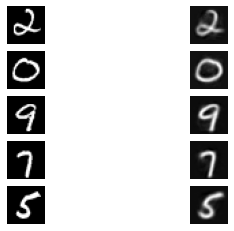

In [84]:
num_images = 5
idx = np.random.permutation(x_test.shape[0])[0:num_images]
y_pred = []
img = []
supports = []
for i,idx in enumerate(idx):
  img.append(x_test[idx][:,:,0])
  y_t = np.array(model.predict(x_test[idx:idx+1])[0])
  y_pred.append(y_t.reshape(28,28))
  sup = np.array(model.predict(x_test[idx:idx+1])[1])
  sup = sup.reshape(-1)
  supports.append(np.count_nonzero(sup))

real_idx = np.arange(1,num_images*2,2)
fake_idx = np.arange(2,num_images*2 + 1,2)
for i in range(num_images):
  plt.subplot(num_images,2,real_idx[i])
  plt.axis('off')
  plt.imshow(img[i],cmap="gray")
  plt.subplot(num_images,2,fake_idx[i])
  plt.axis('off')
  plt.imshow(y_pred[i],cmap="gray")

print("average support = ", np.sum(supports)/len(supports))